In [1]:
!pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pickle

In [4]:
filename = '/content/drive/My Drive/data.pkl'         ###load the whole data to create tokenizer
data = pickle.load(open(filename,'rb'))
data.shape

(70000, 2)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [7]:
english_tokenizer = create_tokens(data[:,0])       ###fit a tokenizer
german_tokenizer = create_tokens(data[:,1])

In [8]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [9]:
def max_len_sen(data):                       ###function to calculate maximum length
    return max(len(line.split()) for line in data)

In [10]:
eng_vocab = len(english_tokenizer.word_index)+1
german_vocab = len(german_tokenizer.word_index)+1
print('Vocabulary size of english words is {}'.format(eng_vocab))
print('Vocabulary size of german words is {}'.format(german_vocab))

Vocabulary size of english words is 11417
Vocabulary size of german words is 21677


In [11]:
eng_len = max_len_sen(data[:,0])
ger_len = max_len_sen(data[:,1])
print ('Maximum length in English is {}'.format(eng_len))
print ('Maximum length in German is {}'.format(ger_len))

Maximum length in English is 44
Maximum length in German is 45


In [12]:
filename1 = '/content/drive/My Drive/eng-ger_train.pkl'                   ###load training, validation and test data
filename2 = '/content/drive/My Drive/eng-ger_val.pkl' 
filename3 = '/content/drive/My Drive/eng-ger_test.pkl'       
train = pickle.load(open(filename1,'rb'))
val = pickle.load(open(filename2,'rb'))
test = pickle.load(open(filename3,'rb'))
train.shape, val.shape, test.shape

((50000, 2), (10000, 2), (10000, 2))

In [13]:
X_train = encode_sentences(english_tokenizer,eng_len,train[:,0])          ###pad the data to maximum length
X_val = encode_sentences(english_tokenizer,eng_len,val[:,0])              ### X ---> English, Y ---> German
X_test= encode_sentences(english_tokenizer,eng_len,test[:,0])
Y_train = encode_sentences(german_tokenizer,ger_len,train[:,1])
Y_val = encode_sentences(german_tokenizer,ger_len,val[:,1])
Y_test = encode_sentences(german_tokenizer,ger_len,test[:,1])

In [14]:
print(X_train.shape)
print(X_val.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(50000, 44)
(10000, 44)
(10000, 44)
(50000, 45)
(10000, 45)
(10000, 45)


In [15]:
from keras.models import Sequential, load_model,Model
from keras.layers import Embedding
from keras.layers import Dense, Dropout, LSTM, Bidirectional, RepeatVector, TimeDistributed, Concatenate
from keras.layers import Dropout,Input
from keras.callbacks import ModelCheckpoint
import numpy as np

In [16]:
units = 256                         ###define parameters of the model
out_timesteps = ger_len
target_vocab= german_vocab 

In [17]:
model = Sequential()
model.add(Embedding(eng_vocab,units*2, input_length=eng_len, mask_zero=True)) 
model.add(Dropout(0.5))                  
model.add(Bidirectional(LSTM(units,recurrent_dropout=0.5)))            ###1 layer bidirectional encoder
model.add(RepeatVector(out_timesteps))
model.add(LSTM(units*2, return_sequences= True, recurrent_dropout=0.5))  ### 1 layer unidirectional decoder
model.add(TimeDistributed(Dense(target_vocab, activation='softmax', kernel_initializer= 'glorot_uniform')))


In [18]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')


In [ ]:
filename = '/content/drive/My Drive/encoder-decoder(unconditional).h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 512)           5845504   
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 45, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 512)           2099200   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 45, 21677)         11120301  
Total params: 20,639,917
Trainable params: 20,639,917
Non-trainable params: 0
__________________________________________

In [ ]:
history= model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1), 
          epochs=60, batch_size=256, 
          validation_data = (X_val, Y_val.reshape(Y_val.shape[0],Y_val.shape[1], 1)),
           verbose=1, callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 292s 6ms/step - loss: 1.5031 - val_loss: 1.0210

Epoch 00001: val_loss improved from inf to 1.02098, saving model to /content/drive/My Drive/encoder-decoder(unconditional).h5
Epoch 2/60
50000/50000 [==============================] - 288s 6ms/step - loss: 1.0084 - val_loss: 0.9984

Epoch 00002: val_loss improved from 1.02098 to 0.99839, saving model to /content/drive/My Drive/encoder-decoder(unconditional).h5
Epoch 3/60
50000/50000 [==============================] - 289s 6ms/step - loss: 0.9876 - val_loss: 0.9864

Epoch 00003: val_loss improved from 0.99839 to 0.98639, saving model to /content/drive/My Drive/encoder-decoder(unconditional).h5
Epoch 4/60
50000/50000 [==============================] - 287s 6ms/step - loss: 0.9740 - val_loss: 0.9792

Epoch 00004: val_loss improved from 0.98639 to 0.97919, saving model to /content/drive/My Drive/encoder-decoder(unconditional).h5
Epoch 

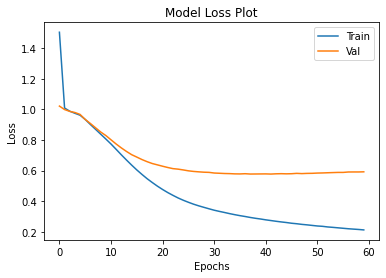

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'],loc = 'upper right')
plt.show()

In [27]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)
 
  

In [22]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model,tokenizer, source)
        raw_src, raw_target = raw_dataset[i]
        if i % 1000:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        ref = [raw_target.split()]
        actual.append(ref)
        predicted.append(translation.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 


In [23]:
from keras.models import load_model

In [24]:
model = load_model('/content/drive/My Drive/encoder-decoder(unconditional).h5')

In [25]:
from nltk.translate.bleu_score import corpus_bleu

In [28]:
evaluate_model(model,german_tokenizer,X_test,test)   ###evaluate on test data

Streaming output truncated to the last 5000 lines.
src=[the two ladies smiled at each other], target=[die zwei damen lächelten einander zu], predicted=[die beiden beiden sich einander sich]
src=[we dont have any proof], target=[wir haben keinen beweis], predicted=[wir haben keinen beweis beweis]
src=[she ignored him all day], target=[sie ignorierte ihn den ganzen tag], predicted=[sie hat ihn den ganzen tag]
src=[the ceremony was impressive], target=[die zeremonie war eindrucksvoll], predicted=[die nebel war]
src=[i hate driving], target=[ich kann fahren nicht ab], predicted=[ich kann absolut fahren]
src=[why thank me], target=[warum dankst du mir], predicted=[warum danke mich]
src=[its been one step forward and two steps back with toms health lately], target=[toms genesung hat in der letzten zeit einen rückschlag erlitten], predicted=[es ist schon der und und und und und und in in in in]
src=[pickpockets target tourists], target=[taschendiebe nehmen reisende aufs korn], predicted=[krie